In [9]:
# autoreload
%load_ext autoreload
%autoreload 2

from model.stratified_transformer import Stratified
from util import config

/data/vision/polina/projects/wmh/dhollidt/conda/envs/stratified/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [11]:
args = config.load_cfg_from_cfg_file("../config/s3dis/s3dis_stratified_transformer.yaml")


args.patch_size = args.grid_size * args.patch_size
args.window_size = [args.patch_size * args.window_size * (2**i) for i in range(args.num_layers)]
args.grid_sizes = [args.patch_size * (2**i) for i in range(args.num_layers)]
args.quant_sizes = [args.quant_size * (2**i) for i in range(args.num_layers)]

print("patch_size: ", args.patch_size)
print("window_size: ", args.window_size)
print("grid_sizes: ", args.grid_sizes)
print("quant_sizes: ", args.quant_sizes)

model = Stratified(args.downsample_scale, args.depths, args.channels, args.num_heads, args.window_size, \
    args.up_k, args.grid_sizes, args.quant_sizes, rel_query=args.rel_query, \
    rel_key=args.rel_key, rel_value=args.rel_value, drop_path_rate=args.drop_path_rate, concat_xyz=args.concat_xyz, num_classes=args.classes, \
    ratio=args.ratio, k=args.k, prev_grid_size=args.grid_size, sigma=1.0, num_layers=args.num_layers, stem_transformer=args.stem_transformer)

patch_size:  0.04
window_size:  [0.16, 0.32, 0.64, 1.28]
grid_sizes:  [0.04, 0.08, 0.16, 0.32]
quant_sizes:  [0.01, 0.02, 0.04, 0.08]


In [3]:
print('#Model parameters: {}'.format(sum([x.nelement() for x in model.parameters()])))
print("The model is on device: {}".format(next(model.parameters()).device))

#Model parameters: 8064730
The model is on device: cuda:0


In [4]:
import torch
import torch_points_kernels as tp

# get fake data
N = 1024
C = FEATURE_DIM
B = 8
pos = torch.rand(B, N, 3) * 2
features = torch.rand(B, N, C) 

def batch_for_stratified_point_transformer(points, features):
    batch_size = points.shape[0]
    seq_len = points.shape[1]
    points = points.reshape(-1, 3)
    features = features.reshape(-1, features.shape[-1])
    offsets = torch.arange(seq_len, (1 + batch_size) * seq_len, seq_len, dtype=torch.int32)
    
    offset_ = offsets.clone()
    offset_[1:] = offset_[1:] - offset_[:-1]
    batch = torch.cat([torch.tensor([ii]*o) for ii,o in enumerate(offset_)], 0).long()
    
    sigma = 1.0
    radius = 2.5 * args.grid_size * sigma
    neighbor_idx = tp.ball_query(radius, args.max_num_neighbors, points, points, mode="partial_dense", batch_x=batch, batch_y=batch)[0]
    
    # get the neighbour_idx
    
    return points, features, offsets, batch, neighbor_idx

points, features, offsets, batch, neighbour_idx = batch_for_stratified_point_transformer(pos, features)

In [5]:
print(points.shape, features.shape, offsets.shape, batch.shape, neighbour_idx.shape)
print(points.device, features.device, offsets.device, batch.device, neighbour_idx.device)
print(points.dtype, features.dtype, offsets.dtype, batch.dtype, neighbour_idx.dtype)
# bring all the data to the GPU
points, features, offsets, batch, neighbour_idx = points.cuda(), features.cuda(), offsets.cuda(), batch.cuda(), neighbour_idx.cuda()
print(points.device, features.device, offsets.device, batch.device, neighbour_idx.device)

print(offsets)
print(batch)

torch.Size([8192, 3]) torch.Size([8192, 64]) torch.Size([8]) torch.Size([8192]) torch.Size([8192, 34])
cpu cpu cpu cpu cpu
torch.float32 torch.float32 torch.int32 torch.int64 torch.int64
cuda:0 cuda:0 cuda:0 cuda:0 cuda:0
tensor([1024, 2048, 3072, 4096, 5120, 6144, 7168, 8192], device='cuda:0',
       dtype=torch.int32)
tensor([0, 0, 0,  ..., 7, 7, 7], device='cuda:0')


In [6]:
output = model(features, points, offsets, batch, neighbour_idx)


In [7]:
print(output.shape)

torch.Size([8192, 13])


In [9]:
from setuptools import setup, find_packages
print(find_packages())


['util']


In [4]:
# pool of size=3, stride=2
import torch
m = torch.nn.MaxPool1d(3)
input = torch.randn(20, 16, 50)
output = m(input)

In [5]:
output.shape

torch.Size([20, 16, 16])

In [7]:


input[0,0]

tensor([-0.1151,  2.0506, -0.0401,  0.3675,  1.0081,  2.2818, -1.8974, -0.1323,
        -0.5976,  1.2340, -0.3675,  1.0604,  0.7596, -0.8400, -0.6142, -1.3703,
         0.6676, -0.9896,  0.1561, -0.2586, -0.6995, -0.8755, -0.3492,  0.4107,
         0.4724,  1.6706,  0.2198, -0.1270,  0.3754, -0.2655, -0.1218,  0.1816,
         0.4466, -0.2780,  0.0281,  0.3701, -1.7980, -0.7230, -0.2833,  0.4954,
        -2.1742, -0.8040,  0.0121,  0.4883, -0.8902,  1.8773, -1.7302,  0.8808,
         0.3214, -1.2906])

In [8]:
output[0,0]

tensor([ 2.0506,  2.2818, -0.1323,  1.2340,  0.7596,  0.6676,  0.1561,  0.4107,
         1.6706,  0.3754,  0.4466,  0.3701, -0.2833,  0.4954,  0.4883,  1.8773])

points.shape:  (10000, 3)


/tmp/ipykernel_2141254/2725314117.py:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


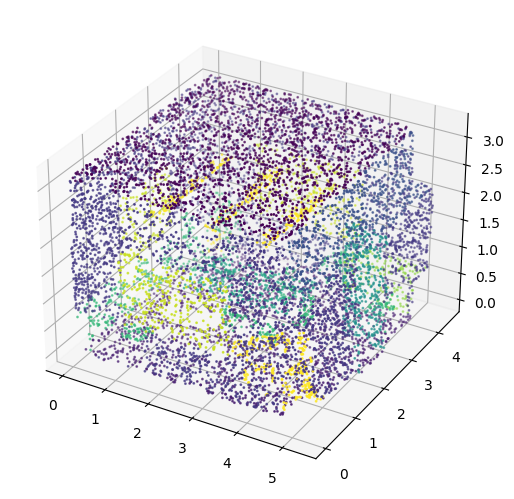

In [15]:
import numpy as np

# load npy array from path
path = "/data/vision/polina/projects/wmh/dhollidt/documents/Pointnet_Pointnet2_pytorch/data/stanford_indoor3d/Area_1_conferenceRoom_1.npy"
# path = "/data/vision/polina/projects/wmh/dhollidt/documents/Pointnet_Pointnet2_pytorch/data/nesf_s3dis_format_65536/Area_1_0.npy"

#load array
data = np.load(path)
# select 80000 rows randomly
data = data[np.random.choice(data.shape[0], 10000, replace=False), :]
points = data[:, 0:3]
rgb = data[:, 3:6]
label = data[:, 6]

print("points.shape: ", points.shape)
# visualize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=label, s=1)
plt.show()

In [20]:
import numpy as np
import os
from functools import reduce

def get_class_distribution(directory):
    """
    Given a directory containing .npy files, return the distribution of classes
    across all files.
    
    Parameters:
    - directory: Path to the directory containing the .npy files
    
    Returns:
    - A dictionary with class labels as keys and counts as values
    """
    class_distribution = {}
    
    # Loop through all the .npy files in the directory
    for file_name in os.listdir(directory):
        if file_name.endswith('.npy'):
            file_path = os.path.join(directory, file_name)
            
            # Load the array from the .npy file
            array = np.load(file_path)
            
            # Extract the label column
            labels = array[:, -1]
            
            # Update the class distribution
            unique, counts = np.unique(labels, return_counts=True)
            for u, c in zip(unique, counts):
                class_distribution[u] = class_distribution.get(u, 0) + c
                
    return class_distribution

# Example Usage
directory_path = '/data/vision/polina/projects/wmh/dhollidt/documents/Pointnet_Pointnet2_pytorch/data/nesf_s3dis_format_65536'  # Update this path
distribution = get_class_distribution(directory_path)
# normalize the distribution
sum = reduce(lambda x, y: x + y, distribution.values())
distribution = {k: v/sum*100 for k, v in distribution.items()}
print(distribution)


{0.0: 0.25096567549074583, 3.0: 31.7106305922274, 4.0: 12.833186589564868, 5.0: 40.61930945004495, 1.0: 4.557916424560593, 2.0: 10.027991268111437}


In [2]:
import numpy as np
import os
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

# Get list of all .npy files in the folder
folder_path = '/data/vision/polina/projects/wmh/dhollidt/documents/Pointnet_Pointnet2_pytorch/data/nesf_s3dis_format_65536'  # Update this path
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npy')]
current_index = [0]  # Use a list to hold the current index to make it mutable inside callback

# Initialize Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='pointcloud-plot'),
    html.Button('Previous', id='prev-button', n_clicks=0),
    html.Button('Next', id='next-button', n_clicks=0)
])

@app.callback(
    Output('pointcloud-plot', 'figure'),
    Input('prev-button', 'n_clicks'),
    Input('next-button', 'n_clicks')
)
def update_pointcloud(prev_clicks, next_clicks):
    changed_id = [p['prop_id'] for p in dash.callback_context.triggered][0]
    
    # Determine which button was pressed and update index accordingly
    if "prev-button" in changed_id and current_index[0] > 0:
        current_index[0] -= 1
    elif "next-button" in changed_id and current_index[0] < len(all_files) - 1:
        current_index[0] += 1

    # Load point cloud from current file
    pointcloud = np.load(all_files[current_index[0]])
    x, y, z = pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2]
    colors = pointcloud[:, 3:6]  # Assuming RGB values are in [0, 255] range
    labels = pointcloud[:, -1]

    # Create 3D scatter plot
    fig = px.scatter_3d(
        x=x, y=y, z=z, color=labels, 
        color_continuous_scale='Viridis', 
        range_color=[labels.min(), labels.max()],
        render_mode='webgl'
    )
    
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=7030)


Dash is running on http://127.0.0.1:8051/

 * Serving Flask app '__main__'
 * Debug mode: on


/data/vision/polina/projects/wmh/dhollidt/conda/envs/nerfstudio2/lib/python3.8/site-packages/traitlets/traitlets.py:2548: FutureWarning: Supporting extra quotes around strings is deprecated in traitlets 5.0. You can use 'hmac-sha256' instead of '"hmac-sha256"' if you require traitlets >=5.
  warn(
/data/vision/polina/projects/wmh/dhollidt/conda/envs/nerfstudio2/lib/python3.8/site-packages/traitlets/traitlets.py:2499: FutureWarning: Supporting extra quotes around Bytes is deprecated in traitlets 5.0. Use '1f4d90b1-648d-4cb7-9c83-3d3595fb4358' instead of 'b"1f4d90b1-648d-4cb7-9c83-3d3595fb4358"'.
  warn(
Traceback (most recent call last):
  File "/data/vision/polina/projects/wmh/dhollidt/conda/envs/nerfstudio2/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/data/vision/polina/projects/wmh/dhollidt/conda/envs/nerfstudio2/lib/python3.8/site-packages/traitlets/config/application.py", line 1042, in launch_instance
    app.initia

SystemExit: 1

/data/vision/polina/projects/wmh/dhollidt/conda/envs/nerfstudio2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
